# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 372655748.56it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120293638.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86220159.04it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19360293.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


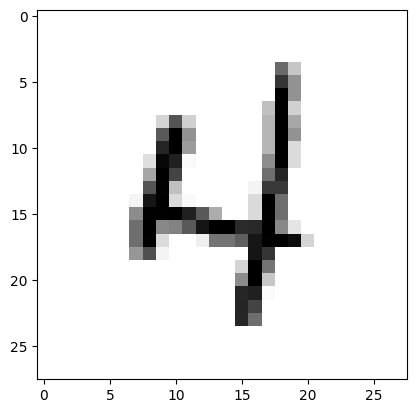

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

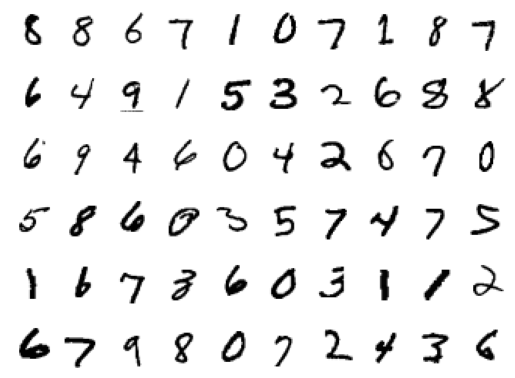

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block 28  >>> 64
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26 >>> 62

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24. >>> 60
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22 >>> 58

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11 >>> 29

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9 >>> 27
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7 >>> 25

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7 >>> 25
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.45831695199012756 Batch_id=468 Accuracy=77.56: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.3813, Accuracy: 9289/10000 (92.89%)

EPOCH: 1


Loss=0.18067334592342377 Batch_id=468 Accuracy=95.24: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.1719, Accuracy: 9681/10000 (96.81%)

EPOCH: 2


Loss=0.17074917256832123 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.1327, Accuracy: 9723/10000 (97.23%)

EPOCH: 3


Loss=0.15976405143737793 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.1255, Accuracy: 9688/10000 (96.88%)

EPOCH: 4


Loss=0.08376546949148178 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]



Test set: Average loss: 0.1011, Accuracy: 9767/10000 (97.67%)

EPOCH: 5


Loss=0.11513849347829819 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.1003, Accuracy: 9742/10000 (97.42%)

EPOCH: 6


Loss=0.08511310815811157 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:19<00:00, 24.19it/s]



Test set: Average loss: 0.0762, Accuracy: 9808/10000 (98.08%)

EPOCH: 7


Loss=0.15058709681034088 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0701, Accuracy: 9822/10000 (98.22%)

EPOCH: 8


Loss=0.09954851120710373 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0667, Accuracy: 9849/10000 (98.49%)

EPOCH: 9


Loss=0.041525889188051224 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0655, Accuracy: 9823/10000 (98.23%)

EPOCH: 10


Loss=0.060600731521844864 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]



Test set: Average loss: 0.0597, Accuracy: 9855/10000 (98.55%)

EPOCH: 11


Loss=0.12795192003250122 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0601, Accuracy: 9851/10000 (98.51%)

EPOCH: 12


Loss=0.08425838500261307 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0508, Accuracy: 9877/10000 (98.77%)

EPOCH: 13


Loss=0.07561803609132767 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.0480, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Loss=0.05286124348640442 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0446, Accuracy: 9885/10000 (98.85%)

EPOCH: 15


Loss=0.03598750755190849 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]



Test set: Average loss: 0.0511, Accuracy: 9868/10000 (98.68%)

EPOCH: 16


Loss=0.08848852664232254 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0432, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.029468616470694542 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0461, Accuracy: 9871/10000 (98.71%)

EPOCH: 18


Loss=0.06873119622468948 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0472, Accuracy: 9878/10000 (98.78%)

EPOCH: 19


Loss=0.05691450461745262 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0462, Accuracy: 9863/10000 (98.63%)



Text(0.5, 1.0, 'Test Accuracy')

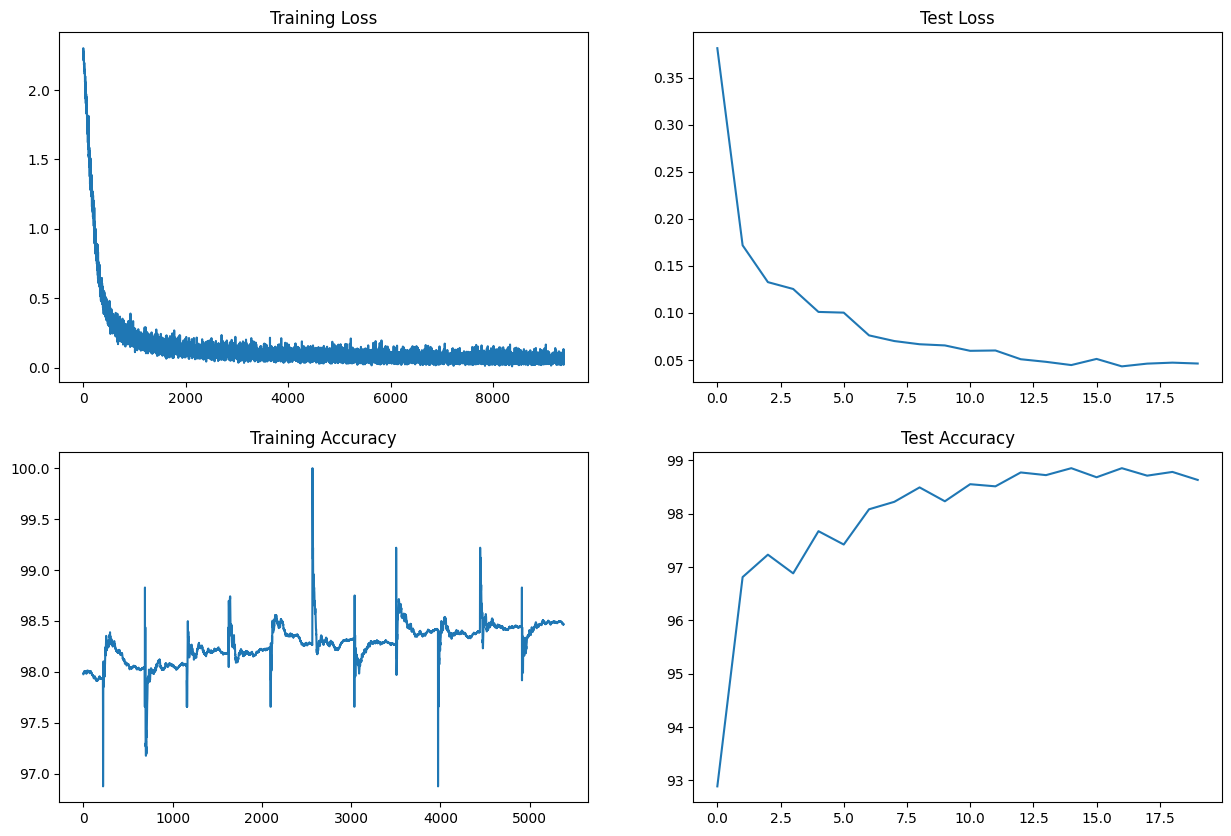

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Iteration 1**

**Target**:
Reduce the #parameters to make the model lighter. Since the number of distinct output predictions needed are 10, The least number of kernels we can use in each layer is 10.


**Results**:
Parameters: 10,790
Best Training Accuracy: 99.2
Best Test Accuracy: 98.94
The accuracy is lower than needed. Batch Normalization can be tried to increase this. Difference between train & test still exists. Dropout might be needed.

**Analysis**:
Number of parameters are much lower. However, they are still above 8000. Also, notice that ~45% of the number of parameters are coming from the last layer of kernel size 7. So, need to optimize this further. GAP may be required.


**Iteration 2**

**Target**:
Increase the model accuracy & reduce the difference between test & train accuracy


**Results**:
Parameters:10,970 (Slight increase due to Batch normalization)
Best Training Accuracy: 99.87
Best Test Accuracy: 99.21

**Analysis**:

Model accuracy has increased significantly due to batch normalization. Unable to push the test accuracy beyond 99.21. Need to shrink difference between test & train accuracy.

**Iteration 3**

**Target**:
Reduce the difference between test & train accuracy. Ran for more number of epochs to monitor consistency of lower difference between train & test accuracies.


**Results**:
Parameters:10,970
Best Training Accuracy: 99.35
Best Test Accuracy: 99.23

**Analysis**:
Adding dropout of 10% at every layer helps reduce the difference between test & train accuracies. However, it's not possible to push the test accuracy higher & get to 99.4 consistently within 15 epochs. Also, #parameters still need to be reduced. GAP should be tried now.


**Iteration 4**

**Target**:
Increase the test accuracy. Reduce the number of parameters.


**Results**:
Parameters:6,070
Best Training Accuracy: 98.47
Best Test Accuracy: 98.85

**Analysis**: Model parameters are now within constraints.

